In [146]:
import torch
from safetensors.torch import load_model
from torch.utils.data import DataLoader

import config as cfg
import lidc
import metrics
from model import Sampler, build_model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

test_dataset = lidc.test_dataset()
test_loader = DataLoader(test_dataset, batch_size=1)

model = build_model(cfg)
load_model(model, "checkpoints/last.safetensors")
model.to(device)

_ = model.eval()

In [4]:
import torch.nn as nn
from torch.func import jacrev
from torchdiffeq import odeint
from tqdm.auto import tqdm


def exact_div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)

    def div(x):
        return torch.trace(J(x.unsqueeze(0)).squeeze())

    return div


def hutch_div_fn(u):
    """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator."""

    def div_fn(x):
        epsilon = torch.randn_like(x)
        with torch.enable_grad():
            fn_eps = torch.sum(u(x) * epsilon)
        grad_fn_eps = torch.autograd.grad(fn_eps, x, create_graph=True)[0]
        return torch.sum(grad_fn_eps * epsilon, dim=tuple(range(1, len(x.shape))))

    return div_fn


def hutch_trace(x_in, x_out, noise=None):
    jvp = torch.autograd.grad(x_out, x_in, noise, create_graph=True)[0]
    return torch.einsum("bi,bi->b", (jvp, noise))


def log_likelihood_isotropic_gaussian(X, mu=None, sigma=1.0):
    """
    Computes the log-likelihood of a sample under an isotropic Gaussian distribution.

    Args:
        X (torch.Tensor): Input tensor of shape (N, C, H, W).
        mu (torch.Tensor or None): Mean tensor of the same shape as X (default: zero mean).
        sigma (float): Standard deviation (assumed isotropic).

    Returns:
        torch.Tensor: Scalar log-likelihood value.
    """
    if mu is None:
        mu = torch.zeros_like(X)  # Default to zero mean

    D = X.numel()  # Total number of elements
    log_likelihood = -0.5 * D * torch.log(torch.tensor(2 * torch.pi * sigma**2)) - (0.5 / sigma**2) * torch.sum(
        (X - mu) ** 2
    )

    return log_likelihood


class Sampler(nn.Module):
    def __init__(self, model: nn.Module, num_steps: int = 250):
        super().__init__()
        self.model = model
        self.num_steps = num_steps

    def forward(self, t, x):
        shaped_t = torch.ones(x.shape[0], device=x.device) * t
        vec = self.model(shaped_t, x)
        # Zero vectorfield for conditional variable
        cond_vec = torch.zeros_like(vec)
        return torch.cat([vec, cond_vec], dim=1)

    @torch.no_grad()
    def sample(self, cond):
        x0 = torch.randn_like(cond)
        x = torch.cat([x0, cond], dim=1)

        time = torch.linspace(0, 1, self.num_steps + 1, device=x.device)
        x1 = odeint(self, x, t=time, method="euler")[-1]

        # Excluding cond
        x1 = x1[:, 0]

        # Real to Categorical
        sample = torch.where(x1 > 0, 1, 0)
        return sample

    @torch.no_grad()
    def sample_n(self, cond, n, use_tqdm=False):
        samples = []
        for _ in tqdm(range(n), disable=not use_tqdm):
            samples.append(self.sample(cond))

        return torch.stack(samples, dim=1)

In [5]:
class SamplerWithNLL(nn.Module):
    def __init__(self, model: nn.Module, num_steps: int = 250):
        super().__init__()
        self.model = model
        self.num_steps = num_steps
        self.cond = None

    def forward(self, t, x):
        x = x[:, :-1].requires_grad_(True)
        cond = self.cond.reshape(-1, 1, 128, 128)
        shaped_t = torch.ones(x.shape[0], device=x.device) * t

        def vecfield(x):
            x = x.reshape(-1, 1, 128, 128)
            x = torch.cat([x, cond], dim=1)
            vec = self.model(shaped_t, x)
            vec = vec.flatten(start_dim=1)
            return vec

        with torch.enable_grad():
            dx = vecfield(x)
        div = hutch_trace(x, dx, torch.randn_like(x))

        return torch.cat([dx.detach(), -div[:, None].detach()], dim=-1)

    def backward(self, t, x):
        x = x[:, :-1].requires_grad_(True)
        cond = self.cond.reshape(-1, 1, 128, 128)
        shaped_t = torch.ones(x.shape[0], device=x.device) * t

        def vecfield(x):
            x = x.reshape(-1, 1, 128, 128)
            x = torch.cat([x, cond], dim=1)
            vec = self.model(shaped_t, x)
            vec = vec.flatten(start_dim=1)
            return vec

        with torch.enable_grad():
            dx = vecfield(x)
        div = hutch_trace(x, dx, torch.randn_like(x))

        return torch.cat([dx.detach(), div[:, None].detach()], dim=-1)

    @torch.no_grad()
    def sample(self, cond):
        cond = cond.flatten(start_dim=1)
        self.cond = cond
        x = torch.randn_like(cond)
        ll = torch.zeros(1, 1, device=x.device)

        time = torch.linspace(0, 1, self.num_steps + 1, device=x.device)
        x1 = odeint(self, torch.cat([x, ll], dim=1), t=time, method="euler")[-1]
        ll = x1[:, -1]
        x1 = x1[:, :-1]
        x1 = x1.reshape(-1, 1, 128, 128)
        ll = ll + log_likelihood_isotropic_gaussian(x)

        # Real to Categorical
        sample = torch.where(x1 > 0, 1, 0)
        return sample, ll, x1

    @torch.no_grad()
    def compute_ll(self, x, cond):
        cond = cond.flatten(start_dim=1)
        self.cond = cond
        x = x.flatten(start_dim=1)
        ll = torch.zeros(1, 1, device=x.device)

        time = torch.linspace(1, 0, self.num_steps + 1, device=x.device)
        x0 = odeint(self.backward, torch.cat([x, ll], dim=1), t=time, method="euler")[-1]
        ll = x0[:, -1]
        x0 = x0[:, :-1]
        x0 = x0.reshape(-1, 1, 128, 128)
        ll = ll + log_likelihood_isotropic_gaussian(x0)

        return x0, ll

    @torch.no_grad()
    def sample_n(self, cond, n, use_tqdm=False):
        samples = []
        lls = []
        for _ in tqdm(range(n), disable=not use_tqdm):
            sample, ll, _ = self.sample(cond)
            samples.append(sample)
            lls.append(ll)
        return torch.stack(samples, dim=1), torch.stack(lls, dim=1)

In [6]:
sampler = SamplerWithNLL(model, num_steps=20)

  0%|          | 0/2988 [00:00<?, ?it/s]

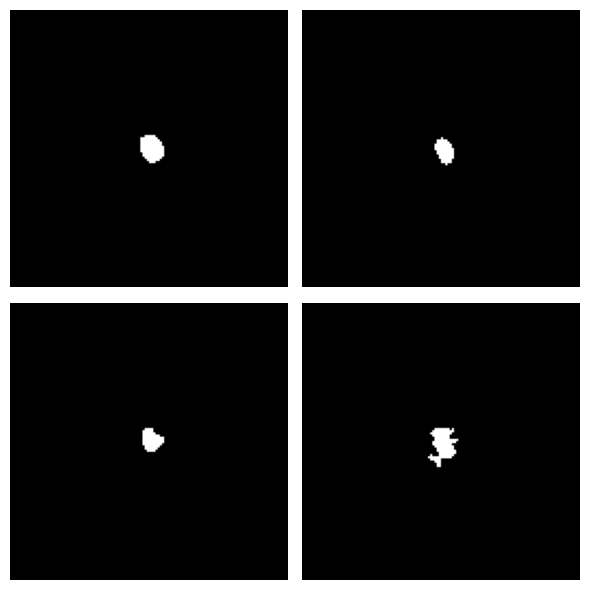

In [148]:
import matplotlib.pyplot as plt

target_idx = 1000
idx = 0
num_labels = 4

for images, labels, _ in tqdm(test_loader):
    if target_idx == idx:
        break
    idx += 1

labels = labels.argmax(dim=2)

fig = plt.figure(figsize=(6, 6))

for i in range(num_labels):
    plt.subplot(2, 2, i + 1)
    plt.imshow(labels[0][i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

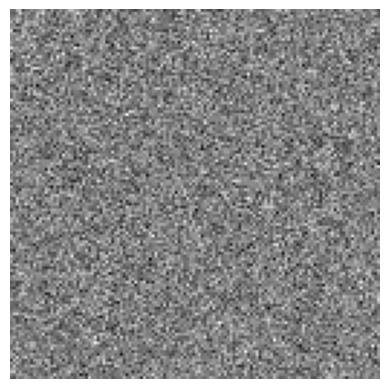

In [161]:
plt.imshow((2*labels[0, -1] - 1)*0 + 1*torch.randn(128, 128), cmap="gray")
plt.axis("off")
plt.show()

In [52]:
n_samples = 16

images, labels = images.to(device), labels.to(device)
preds, lls = sampler.sample_n(images, n_samples, use_tqdm=True)

ged, _, _ = metrics.batched_ged(labels, preds, lidc.NUM_CLASSES)
h_iou = metrics.batched_hungarian_iou(labels, preds, lidc.NUM_CLASSES)
print(f"GED: {ged.mean():.2f}, HM-IoU: {h_iou.mean():.2f}")

  0%|          | 0/16 [00:00<?, ?it/s]

GED: 0.32, HM-IoU: 0.24


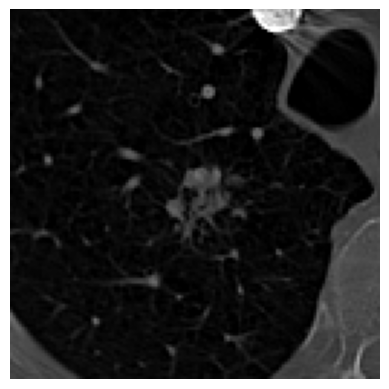

In [144]:
import matplotlib.pyplot as plt

idx = 0
num_labels = 4
image = images[idx, 0].cpu()
label = labels[idx].cpu()
pred = preds[idx].cpu()

plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

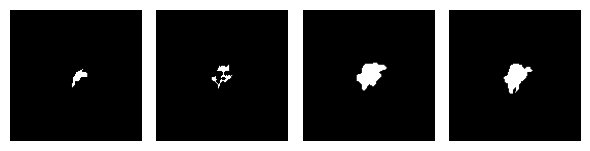

In [145]:
fig = plt.figure(figsize=(6, 6))

for i in range(num_labels):
    plt.subplot(1, 4, i + 1)
    plt.imshow(label[i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

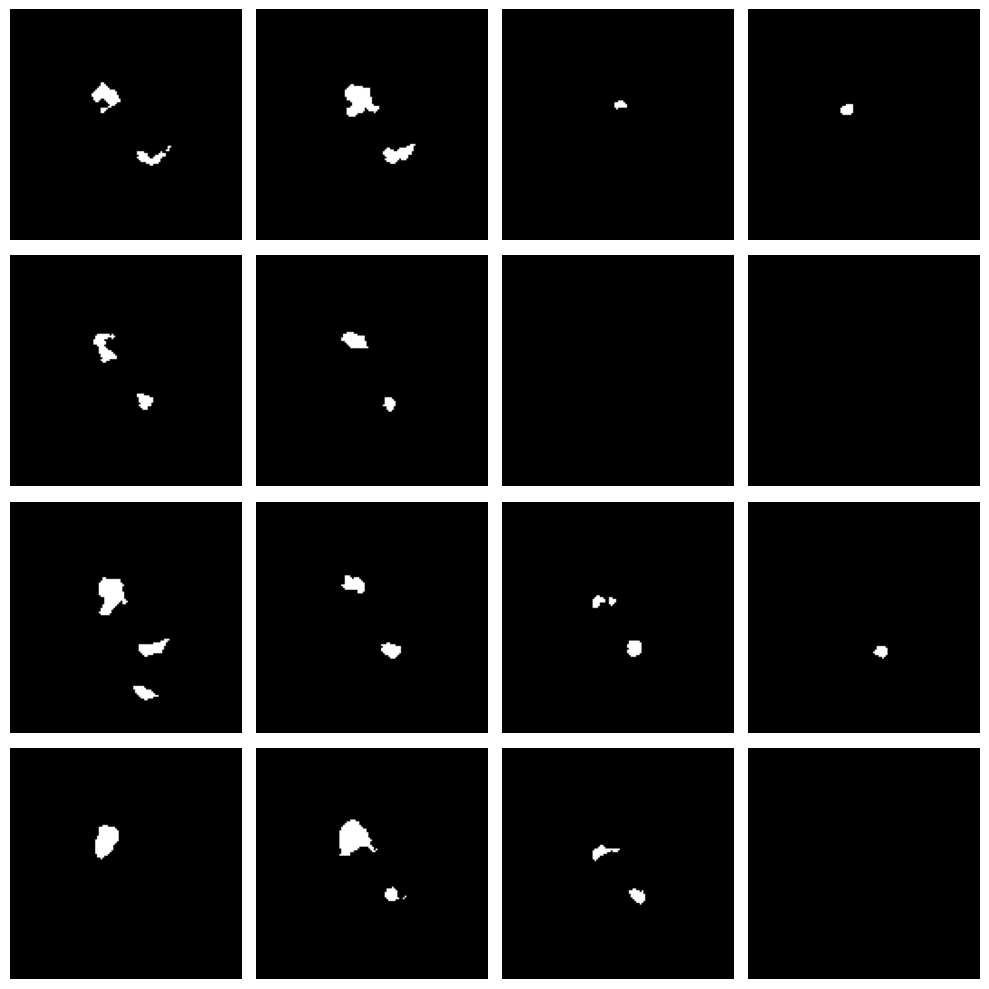

In [55]:
ll = lls.flatten()
ll_normalized = (ll - ll.min()) / (ll.max() - ll.min())

plt.figure(figsize=(10, 10))

sorted_indices = torch.argsort(ll, descending=True)

for i in range(16):
    idx = sorted_indices[i]  # Get the index of the sorted image
    plt.subplot(4, 4, i + 1)
    plt.imshow(pred[idx][0], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


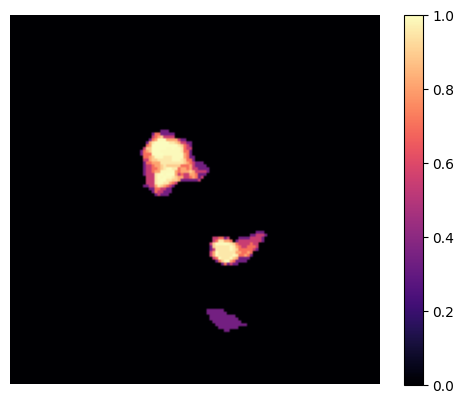

In [56]:
eps = 1e-10
p = pred.mean(dim=0, dtype=torch.float32)
entropy = -p * torch.log2(p + eps) - (1 - p) * torch.log2(1 - p + eps)

plt.imshow(entropy[0], cmap="magma")
plt.axis("off")
plt.colorbar()
plt.show()

In [30]:
sample, ll, x1 = sampler.sample(images)
print(ll)
x0, ll = sampler.compute_ll(x1, images)
ll

tensor([32928.5664], device='cuda:0')


tensor([204597.6875], device='cuda:0')

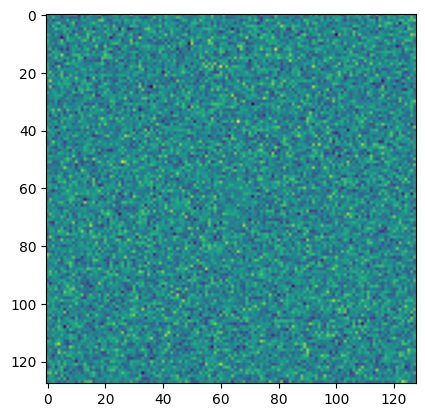

In [31]:
plt.imshow(x0[0, 0].cpu())
plt.show()

  0%|          | 0/2988 [00:00<?, ?it/s]

  0%|          | 0/2988 [00:00<?, ?it/s]

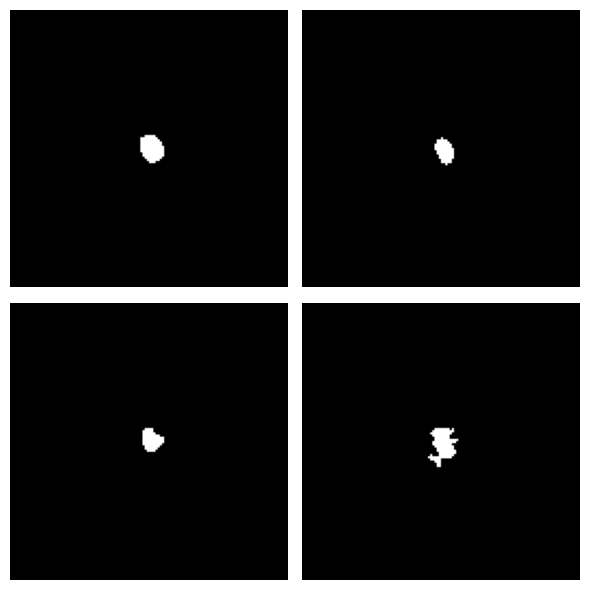

In [116]:
import matplotlib.pyplot as plt

target_idx = 1000
idx = 0
num_labels = 4

for images, labels, _ in tqdm(test_loader):
    if target_idx == idx:
        break
    idx += 1

idx = 0
for images, gt, _ in tqdm(test_loader):
    if idx == 500:
        break
    idx += 1

labels = labels.argmax(dim=2)
gt = gt.argmax(dim=2)

fig = plt.figure(figsize=(6, 6))

for i in range(num_labels):
    plt.subplot(2, 2, i + 1)
    plt.imshow(labels[0][i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

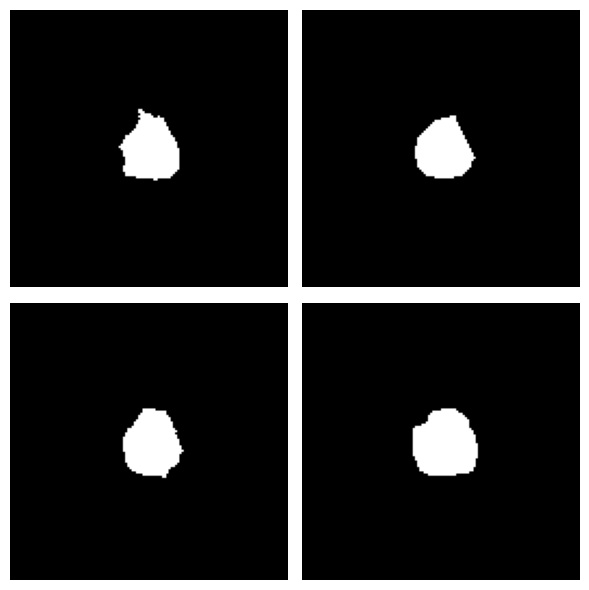

In [128]:
fig = plt.figure(figsize=(6, 6))

for i in range(num_labels):
    plt.subplot(2, 2, i + 1)
    plt.imshow(gt[0][i].cpu(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

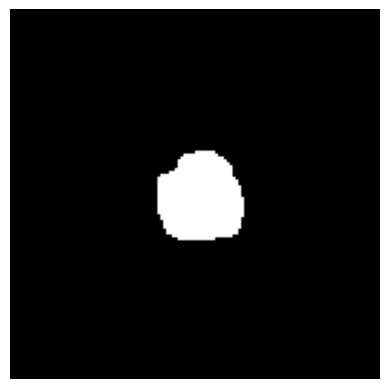

In [131]:
plt.imshow(gt[0][i].cpu(), cmap="gray")
plt.axis("off")
plt.show()

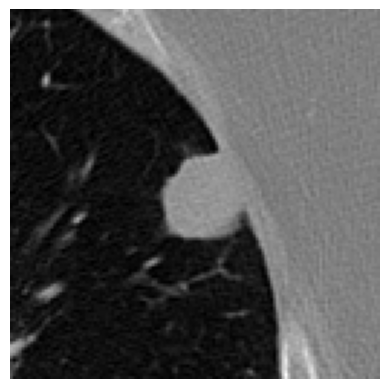

In [118]:
idx = 0
num_labels = 4
image = images[idx, 0].cpu()

plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

In [119]:
images, labels, gt = images.to(device), labels.to(device), gt.to(device)

In [120]:
import numpy as np

n = 10

ood_likelihoods = []

for idx in range(4):
    ood_lls = []
    ood_label = 2 * labels[:, idx].unsqueeze(1).float() - 1

    for i in range(n):
        _, ll = sampler.compute_ll(ood_label, images)
        ood_lls.append(ll.item())
    ood_likelihoods.append(np.mean(ood_lls))

In [121]:
n = 10

gt_likelihoods = []

for idx in range(4):
    gt_lls = []
    gt_label = 2 * labels[:, idx].unsqueeze(1).float() - 1

    for i in range(n):
        _, ll = sampler.compute_ll(gt_label, images)
        gt_lls.append(ll.item())
    gt_likelihoods.append(np.mean(gt_lls))

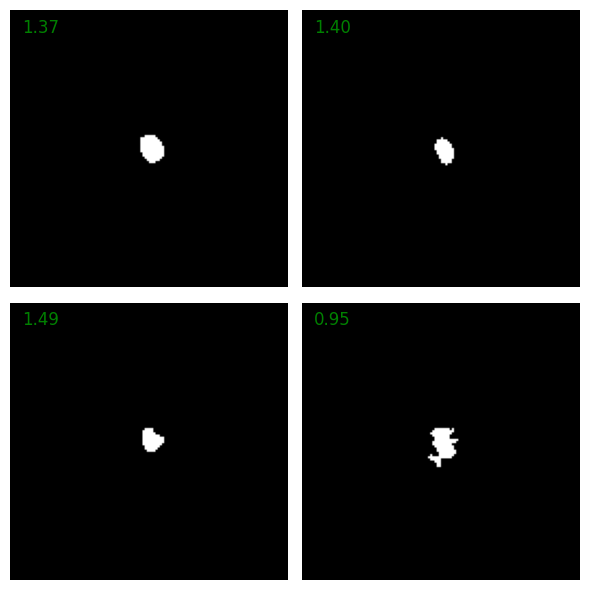

In [123]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))

for i in range(num_labels):
    plt.subplot(2, 2, i + 1)
    plt.imshow(labels[0][i].cpu(), cmap="gray")
    plt.axis("off")
    
    # Overlay log-likelihood values as green text
    log_likelihood = ood_likelihoods[i]  # Assuming you have log_likelihoods defined
    plt.text(
        5, 10, f"{log_likelihood/1e7:.2f}", 
        color="green", fontsize=12, 
        bbox=dict(facecolor="black", alpha=0.5)  # Optional background for contrast
    )

plt.tight_layout()
plt.show()

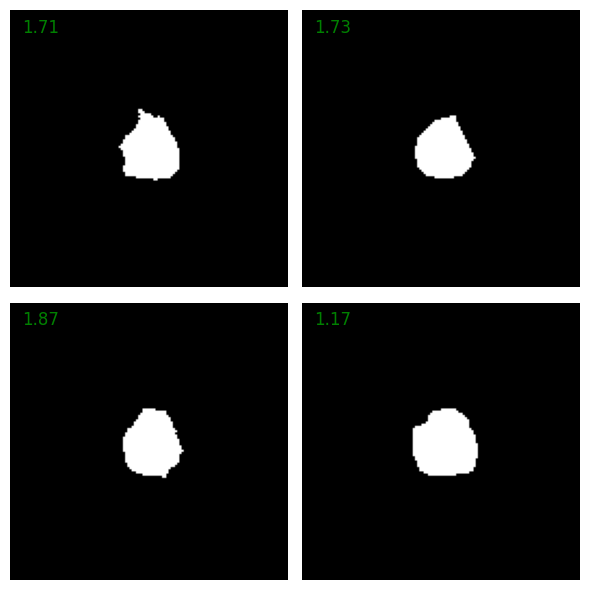

In [125]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))

for i in range(num_labels):
    plt.subplot(2, 2, i + 1)
    plt.imshow(gt[0][i].cpu(), cmap="gray")
    plt.axis("off")
    
    # Overlay log-likelihood values as green text
    log_likelihood = gt_likelihoods[i]  # Assuming you have log_likelihoods defined
    plt.text(
        5, 10, f"{log_likelihood/1e7:.2f}", 
        color="green", fontsize=12, 
        bbox=dict(facecolor="black", alpha=0.5)  # Optional background for contrast
    )

plt.tight_layout()
plt.show()